In [24]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import datetime

In [ ]:
coins = {}
coin_names = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'LTC_USD', 'BCH_USD', 'XLM_USD', 'LINK_USD']
coin_dirs = []
for i in range(len(coin_names)): coin_dirs.append('./datasets/coinbase_hour_candles/' + coin_names[i] + '.feather')
coins = {coin_names[i]:coin_dirs[i] for i in range(len(coin_names))}
coins

In [47]:
df = pd.read_feather(coins['ETH_USD'])
df

,time,open,high,low,close,volume
0,2016-05-18 01:00:00+00:00,12.0,14.0,12.0,12.0,84.039862
1,2016-05-18 02:00:00+00:00,14.0,14.0,14.0,14.0,216.474765
2,2016-05-18 03:00:00+00:00,14.0,14.0,14.0,14.0,0.728000
3,2016-05-18 04:00:00+00:00,14.0,14.0,14.0,14.0,0.000000
4,2016-05-18 05:00:00+00:00,14.0,14.0,14.0,14.0,0.000000
...,...,...,...,...,...,...
31723,2019-12-30 20:00:00+00:00,130.0,130.0,130.0,130.0,312175.121831
31724,2019-12-30 21:00:00+00:00,130.0,130.0,130.0,130.0,544089.756907
31725,2019-12-30 22:00:00+00:00,130.0,130.0,130.0,130.0,177055.847157
31726,2019-12-30 23:00:00+00:00,130.0,130.0,130.0,130.0,183451.913095


In [44]:
# for key in coins:
#     df = pd.read_feather(coins[key])
#     df = df.loc[(df.time >= '2015-1-1') &
#             (df.time <= '2019, 12, 31')]
#     df.reset_index(inplace=True,drop=True)
#     df.to_feather(coins[key])

<AxesSubplot:xlabel='time', ylabel='close'>

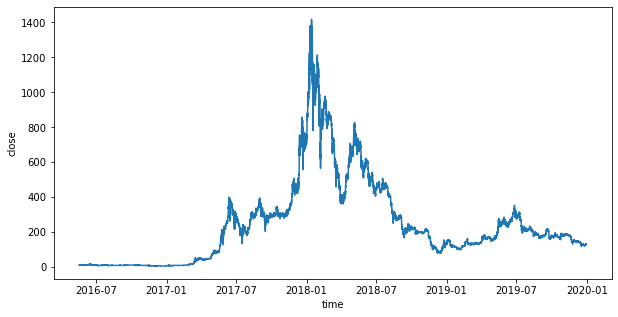

In [48]:
plt.figure(figsize=(10, 5))
sb.lineplot(data=df, x=df.time, y=df.close)